# RPA equation


The linear response TDDFT equations involves the solution of a non-Hermitian eigenvalue equation which can be written as

$$
\left(
\begin{array}{cc}
\mathbf{A} & \mathbf{B} \\
\mathbf{B}^* & \mathbf{A}^*
\end{array}
\right) 
\left(
\begin{array}{c}
\mathbf{X} \\
\mathbf{Y}
\end{array}
\right) 
= \omega
\left(
\begin{array}{cc}
\mathbf{1} & \mathbf{0} \\
\mathbf{0} & \mathbf{-1}
\end{array}
\right) 
\left(
\begin{array}{c}
\mathbf{X} \\
\mathbf{Y}
\end{array}
\right) 
$$

From this, excitation energies and transition amplitudes are obtained from the eigenvalues and corresponding eigenvectors, respectively. For historical reasons, this is referred to as the random-phase approximation (RPA) within TDHF theory, and we adopt this naming convention also for TDDFT.

As an example, consider the ethylene molecule:

In [2]:
import py3Dmol as p3d
import veloxchem as vlx
import matplotlib.pyplot as plt
import numpy as np
from valet import transition_analysis_utils as tau

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


In [3]:
ethene_xyz = """6

C        0.67759997    0.00000000    0.00000000
C       -0.67759997    0.00000000    0.00000000
H        1.21655197    0.92414474    0.00000000
H        1.21655197   -0.92414474    0.00000000
H       -1.21655197   -0.92414474    0.00000000
H       -1.21655197    0.92414474    0.00000000
"""

In [4]:
viewer = p3d.view(width=400, height=300)
viewer.addModel(ethene_xyz)
viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
viewer.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
molecule = vlx.Molecule.from_xyz_string(ethene_xyz)
basis = vlx.MolecularBasis.read(molecule, "6-31G")

scf_drv = vlx.ScfRestrictedDriver()
scf_results = scf_drv.compute(molecule, basis)

* Info * Reading basis set from file: /home/thomas/miniconda3/envs/echem/lib/python3.11/site-packages/veloxchem/basis/6-31G
                                                                                                                          
                                              Molecular Basis (Atomic Basis)                                              
                                                                                                                          
                               Basis: 6-31G                                                                               
                                                                                                                          
                               Atom Contracted GTOs           Primitive GTOs                                              
                                                                                                                          
               

We can extract the MO energies, number of occupied and unoccupied MOs, and the HOMO-LUMO gap:

In [6]:
mo_energy = scf_results["E_alpha"]
nocc = molecule.number_of_alpha_electrons()
norb = mo_energy.shape[0]
nvirt = norb - nocc

print("Number of orbitals:", len(mo_energy))
print("Number of occupied orbitals:", nocc)
print("Number of virtual orbitals:", nvirt)
print("\nMO energies (au):\n", mo_energy)

print(f"\nHOMO-LUMO gap (eV): {27.2114*(mo_energy[nocc] - mo_energy[nocc-1]):.3f}")

Number of orbitals: 26
Number of occupied orbitals: 8
Number of virtual orbitals: 18

MO energies (au):
 [-11.2318428  -11.23036306  -1.03031426  -0.79297209  -0.64755459
  -0.57527959  -0.51027799  -0.3664635    0.17010963   0.26253257
   0.29520837   0.31109777   0.38857996   0.47929591   0.68491581
   0.78814557   0.78870971   0.8870793    0.89030532   0.97978752
   1.15705815   1.20987525   1.2392286    1.2517033    1.36026403
   1.54571226]

HOMO-LUMO gap (eV): 14.601


Looking at the MOs:

In [7]:
viewer = vlx.OrbitalViewer()
viewer.plot(molecule, basis, scf_drv.mol_orbs)

Output()

Dropdown(description='Orbital:', index=7, options=(('  1 occ=2.000 ene=-11.232', 0), ('  2 occ=2.000 ene=-11.2…

## Eigenstates

We first perform a reference calculation using `LinearResponseEigenSolver`, where we calculate the first 12 excited states using a reduced-space Davidson algorithm which can resolve the N lowest eigenvalues (bottom-up).:

In [8]:
lres_drv = vlx.LinearResponseEigenSolver()
rsp_settings = {"nstates": 12}
lres_drv.update_settings(rsp_settings)
lres_out = lres_drv.compute(molecule, basis, scf_results)

                                                                                                                          
                                            Linear Response EigenSolver Setup                                             
                                                                                                                          
                               Number of States                : 12                                                       
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Scheme            : Cauchy Schwarz + Density                                 
                               ERI Screening Threshold         : 1.0e-12                                                  
                

The output contains

In [9]:
lres_out.keys()

dict_keys(['eigenvalues', 'eigenvectors_distributed', 'electric_transition_dipoles', 'velocity_transition_dipoles', 'magnetic_transition_dipoles', 'oscillator_strengths', 'rotatory_strengths', 'excitation_details'])

We create a function for printing the results (energy, oscillator strength, transition moment) in a table:

In [10]:
def print_table(lres):
    print("State Energy [eV]  Osc. str.   TM(x)     TM(y)     TM(z)")
    for i in np.arange(len(lres["eigenvalues"])):
        e, os, x, y, z = (
            27.2114 * lres["eigenvalues"][i],
            lres["oscillator_strengths"][i],
            lres["electric_transition_dipoles"][i][0],
            lres["electric_transition_dipoles"][i][1],
            lres["electric_transition_dipoles"][i][2],
        )
        print(f" {i:2}     {e:.3f}     {os:8.5f}  {x:8.5f}  {y:8.5f}  {z:8.5f}")

print_table(lres_out)

State Energy [eV]  Osc. str.   TM(x)     TM(y)     TM(z)
  0     7.933      0.45586   1.53151   0.00000  -0.00000
  1     9.578      0.00000   0.00000   0.00000   0.00000
  2     9.900      0.00000  -0.00000  -0.00000   0.00000
  3     10.030      0.00012  -0.00000   0.00000  -0.02174
  4     10.461      0.00000   0.00000  -0.00000  -0.00000
  5     11.629      0.00000  -0.00000  -0.00000  -0.00000
  6     12.858      0.00000   0.00000   0.00000  -0.00000
  7     13.538      0.00000   0.00000  -0.00000   0.00000
  8     13.589      0.00000   0.00000  -0.00000  -0.00000
  9     14.819      0.00000   0.00000  -0.00000   0.00000
 10     14.919      0.72579  -1.40916  -0.00000  -0.00000
 11     15.052      1.11817  -0.00000   1.74133  -0.00000


These results were obtained using the solver in VeloxChem, and we will now calculate this explicitly by using the Hessian, overlap matrix, and property gradients.

### Electronic Hessian

The electronic Hessian, $\mathbf{E}^{[2]}$ reads

\begin{equation*}
\mathbf{E}^{[2]} =
	\begin{pmatrix}
    \rule[-5pt]{0pt}{20pt}
	\rule{5pt}{0pt}
	\mathbf{A} & \mathbf{B} \rule{5pt}{0pt}
	\\
    \rule[-10pt]{0pt}{25pt}
    \rule{5pt}{0pt}    
	\mathbf{B}^* & \mathbf{A}^* \\
	\end{pmatrix}
\end{equation*}

For a general hybrid functional, the blocks are constructed as:

\begin{align*}
A_{ia,jb}  &= \delta_{ij} \delta_{ab} (\epsilon_a - \epsilon_i) + (ia|jb) - c_{\textrm{HF}}(ij|ab) + (1-c_{\textrm{HF}})(ia|f_{\textrm{xc}}|jb)
\\
B_{ia,jb}  &= (ia|bj) - c_{\textrm{HF}}(ib|aj) + (1-c_{\textrm{HF}})(ia|f_{\textrm{xc}}|bj)
\end{align*}

For a closed-shell system, the dimension of the $\mathbf{A}$- and $\mathbf{B}$-blocks of the $\mathbf{E}^{[2]}$-matrix equals the number of occupied (spatial) orbitals times the number of virtual orbitals or, in other words

$$\mathrm{dim}\left(\mathbf{E}^{[2]}\right) = 2 \times n_\mathrm{occ} \times n_\mathrm{virt}$$

In the limits we retrieve the TDHF blocks ($c_{\textrm{HF}} = 1$) and pure TDDFT ($c_{\textrm{HF}} = 0$). It can be noted that:

- The matrix is Hermitian and has an internal structure in terms of the matrix blocks $\mathbf{A}$ and $\mathbf{B}$, but not in the full form
- The diagonal elements correspond to differences in energy between the single-excited determinants $|0_i^a\rangle$ and the reference state $|0\rangle$

We get the $\mathbf{E}^{[2]}$-matrix from the `LinearResponseEigenSolver` class object.

In [11]:
lres_drv = vlx.LinearResponseEigenSolver()
E2 = lres_drv.get_e2(molecule, basis, scf_results)

* Info * Processing Fock builds... (batch size: 576)                                                                      
* Info *   batch 1/1                                                                                                      


The dimension of the Hessian should be

In [12]:
n = nocc * nvirt
print("Dimension of full Hessian:", 2 * n)

Dimension of full Hessian: 288


Which is verified using `.shape`

In [13]:
print(E2.shape)

(288, 288)


This is a bit too large to print, but we can visualize the matrix using `imshow`:

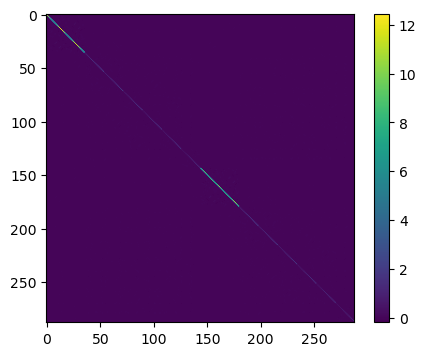

In [14]:
plt.figure(figsize=(5, 4))
plt.imshow(E2)
plt.colorbar()
plt.show()

In order to see the off-diagonal elements better, we subtract the diagonal elements

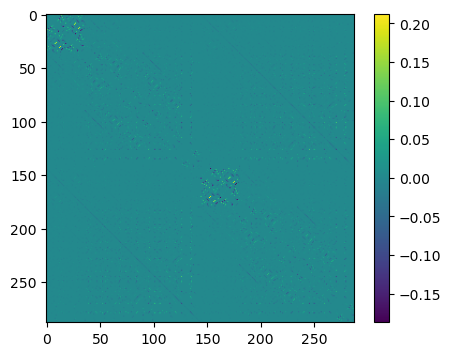

In [17]:
plt.figure(figsize=(5, 4))
plt.imshow(np.array(E2) - np.array(E2)*np.identity(2 * n))
plt.colorbar()
plt.show()

Matrix elements can be directly accessed, such as that of the $\pi \rightarrow \pi^{\ast}$ transition

In [18]:
idx = (nocc - 1) * nvirt # index position for (pi,pi*) excitation
print(f'Diagonal element for the (pi,pi*)-excitation: {E2[idx,idx] : .6f} a.u.')

Diagonal element for the (pi,pi*)-excitation:  0.361149 a.u.


Alternatively, we can in principle determine the elements of the $\mathbf{E}^{[2]}$-matrix from explicit calculations using orbital energies and two-electron integrals in the MO-basis.

In [19]:
# Orbital energies
orbital_energies = scf_results['E_alpha']

# ERI integrals in physicist's notation
moints_drv = vlx.MOIntegralsDriver()
isis = moints_drv.compute_in_memory(molecule, basis, scf_drv.mol_orbs, "phys_OVOV")
iiss = moints_drv.compute_in_memory(molecule, basis, scf_drv.mol_orbs, "phys_OOVV")

# Determine the specific diagonal matrix element of E[2] explicitly 
diag_element = orbital_energies[nocc] - orbital_energies[nocc - 1] +(- isis[nocc - 1,0,nocc - 1,0] + 2 * iiss[nocc - 1,nocc - 1,0,0])
print(f'Diagonal element (explicit calculation): {diag_element : .6f}  a.u.')

Diagonal element (explicit calculation):  0.361149  a.u.


## Overlap matrix


The overlap matrix, $\mathbf{S}^{[2]}$, in the SCF approximation is trivial and equal to

$$
\mathbf{S}^{[2]}  =
	\begin{pmatrix}
    \rule[-5pt]{0pt}{20pt}
	\rule{5pt}{0pt}
	\mathbf{1} & \mathbf{0} \rule{5pt}{0pt}
	\\
    \rule[-10pt]{0pt}{25pt}
    \rule{5pt}{0pt}    
	\mathbf{0} & -\mathbf{1} \\
	\end{pmatrix}
$$

where $\mathbf{1}$ and the $\mathbf{1}$ are understood to be the identity and zero matrices, respectively, of the same rank as sub-blocks $\mathbf{A}$ and $\mathbf{B}$ in the electronic Hessian. We construct this as

In [20]:
S2 = np.identity(2 * n)
S2[n:, n:] *= -1

## Property gradient


In the SCF approximation, the property gradient, $\mathbf{V}^{[1]}$, takes the form

\begin{equation*}
  \mathbf{V}^{[1]} =
      \begin{pmatrix}
    \rule[-5pt]{0pt}{15pt}
    \mathbf{g}
       \\
    \rule[-5pt]{0pt}{0pt}
     -\mathbf{g}^*
\\
  \end{pmatrix}
\end{equation*}

We get the $\mathbf{V}^{\omega,[1]}$-vector from the `LinearResponseSolver` class object. We assume the perturbation operator to equal minus the electric dipole moment operator along the $x$-axis, i.e., the molecular C$-$C axis.

In [21]:
lrs_drv = vlx.LinearResponseSolver()

mu_x = lrs_drv.get_prop_grad("electric dipole", "x", molecule, basis, scf_results)[0]
mu_y = lrs_drv.get_prop_grad("electric dipole", "y", molecule, basis, scf_results)[0]
mu_z = lrs_drv.get_prop_grad("electric dipole", "z", molecule, basis, scf_results)[0]

V1x = -mu_x
V1y = -mu_y
V1z = -mu_z

print("Dimension of V[1] vectors:", V1x.shape[0])

Dimension of V[1] vectors: 288


We can illustrate these vectors as

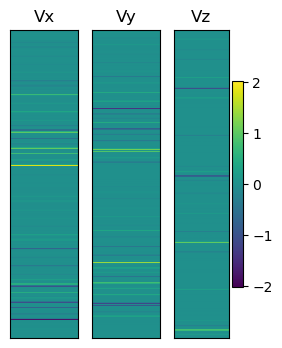

In [22]:
plt.figure(figsize=(3, 4))
Vmtrx = np.zeros((2 * n, 100))
plt.subplot(131)
plt.title("Vx")
for i in np.arange(100):
    Vmtrx[:, i] = V1x
plt.imshow(
    Vmtrx, vmin=np.min([V1x, V1y, V1z]), vmax=np.max([V1x, V1y, V1z]), aspect="auto"
)
plt.xticks([])
plt.yticks([])

plt.subplot(132)
plt.title("Vy")
for i in np.arange(100):
    Vmtrx[:, i] = V1y
plt.imshow(
    Vmtrx, vmin=np.min([V1x, V1y, V1z]), vmax=np.max([V1x, V1y, V1z]), aspect="auto"
)
plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.title("Vz")
for i in np.arange(100):
    Vmtrx[:, i] = V1z
plt.imshow(
    Vmtrx, vmin=np.min([V1x, V1y, V1z]), vmax=np.max([V1x, V1y, V1z]), aspect="auto"
)
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

For the (pi,pi*) excitation we assume the perturbation operator to equal minus the electric dipole moment operator along the $x$-axis, i.e., the molecular C$-$C axis.

In [23]:
lrs_drv = vlx.LinearResponseSolver()

print('Elements for (pi,pi*)-excitation:')
print(f'(upper)   g: {V1x[idx] : .6f}')
print(f'(lower) -g*: {V1x[n + idx] : .6f}')

Elements for (pi,pi*)-excitation:
(upper)   g:  2.005214
(lower) -g*: -2.005214


Alternatively, we can in principle determine the elements of the $\mathbf{V}^{\omega,[1]}$-vector from explicit calculations using one-electron integrals of the perturbation operator in the MO-basis. The property integrals are available in AO-basis from the `ElectricDipoleIntegralsDriver` class object and we transfer them to the MO-basis with use of the MO-coefficients.

In [24]:
dipole_drv = vlx.ElectricDipoleIntegralsDriver()
C = scf_results['C_alpha']

dipole_matrices = dipole_drv.compute(molecule, basis)
x_ao = -dipole_matrices.x_to_numpy()
x_mo = np.matmul(C.T, np.matmul(x_ao, C))

# sqrt(2) for consistent normalization
print(f'{x_mo[nocc - 1,nocc]*np.sqrt(2.0) : .6f}')

 2.005214


## Excitation energies

Denote the eigenvectors of the generalized eigenvalue equation as $\mathbf{X}_e$

$$
  \mathbf{E}^{[2]} \mathbf{X}_e = \lambda_e \mathbf{S}^{[2]} \mathbf{X}_e, \quad e = -n,\ldots,-1,1,\ldots,n ,
$$
 
where the matrix dimension is $2n$. We find the set of eigenvalues and eigenvectors by diagonalizing the non-Hermitian matrix $\left(\mathbf{S}^{[2]}\right)^{-1} \mathbf{E}^{[2]}$

$$
  \mathbf{X}^{-1} \left[ \left(\mathbf{S}^{[2]}\right)^{-1} \mathbf{E}^{[2]} \right] \mathbf{X} = 
  \begin{bmatrix}
    \rule[-5pt]{0pt}{15pt}
    \rule{9pt}{0pt}
    \boldsymbol{\lambda} & \rule{3pt}{0pt} \mathbf{0} \rule{3pt}{0pt} \\
    \rule{3pt}{0pt}
    \mathbf{0} & -\boldsymbol{\lambda} \rule{3pt}{0pt} \\
  \end{bmatrix}
$$

where $\boldsymbol{\lambda}$ is a diagonal matrix of dimension $n$ collecting the eigenvalues with positive index and the columns of $\mathbf{X}$ store the eigenvectors ($\mathbf{X}$ is assumed to be nonsingular). This pairing of eigenvalues has its correspondence in the eigenvectors through

\begin{align*}
  \mathbf{X}_e &=
  \begin{pmatrix}
    \rule[-5pt]{0pt}{15pt}
    \mathbf{Z}_e \\
    \rule[-5pt]{0pt}{0pt}
    \mathbf{Y}_e^* \\
  \end{pmatrix}
\; \mbox{with eigenvalue}\; \lambda_e \\
  \mathbf{X}_{-e} &=
  \begin{pmatrix}
    \rule[-5pt]{0pt}{15pt}
    \mathbf{Y}_{e} \\
    \rule[-5pt]{0pt}{0pt}
    \mathbf{Z}_{e}^* \\
  \end{pmatrix} 
\; \mbox{with eigenvalue}\; -\!\lambda_e 
\end{align*}

The matrix $\mathbf{X}$ will therefore have the structure

\begin{equation*}
  \mathbf{X} = 
  \begin{bmatrix}
    \rule[-5pt]{0pt}{15pt}
    \rule{3pt}{0pt}
    \mathbf{Z} & \rule{3pt}{0pt} \mathbf{Y} \rule{3pt}{0pt} \\
    \rule{8pt}{0pt}
    \mathbf{Y}^* & \rule{3pt}{0pt} \mathbf{Z}^* \rule{3pt}{0pt} \\
  \end{bmatrix}
\end{equation*}

With an appropriate scaling of the eigenvectors $\mathbf{X}_e$, the non-unitary matrix $\mathbf{X}$ achieves a simultaneous diagonalization of the two non-commuting matrices $\mathbf{E}^{[2]}$ and $\mathbf{S}^{[2]}$ as

$$
  \mathbf{X}^\dagger \mathbf{E}^{[2]} \mathbf{X} = 
  \begin{bmatrix}
    \rule[-5pt]{0pt}{15pt}
    \rule{9pt}{0pt}
    \boldsymbol{\lambda} & \rule{3pt}{0pt} \mathbf{0} \rule{3pt}{0pt} \\
    \rule{3pt}{0pt}
    \mathbf{0} & \boldsymbol{\lambda} \rule{3pt}{0pt} \\
  \end{bmatrix} ; \qquad
  \mathbf{X}^\dagger \mathbf{S}^{[2]} \mathbf{X} =
  \begin{bmatrix}
    \rule[-5pt]{0pt}{15pt}
    \rule{8pt}{0pt}
    \mathbf{1} & \rule{5pt}{0pt} \mathbf{0} \rule{3pt}{0pt} \\
    \rule{5pt}{0pt}
    \mathbf{0} & -\mathbf{1} \rule{3pt}{0pt} \\
  \end{bmatrix} 
$$

For each pair of eigenvectors, the second equation involving the metric of the generalized eigenvalue equation defines which of the two that should be indexed with a positive index. We also emphasize that $\mathbf{X}^\dagger \neq \mathbf{X}^{-1}$ and for this reason the $\mathbf{X}_e$'s are eigenvectors neither of $\mathbf{E}^{[2]}$ nor of $\mathbf{S}^{[2]}$, just as the $\lambda_e$'s are not the eigenvalues of $\mathbf{E}^{[2]}$.

The eigenvalues, or excitation energies, can then be calculated by use of `np.linalg.eig` on $\left(\mathbf{S}^{[2]}\right)^{-1} \mathbf{E}^{[2]}$. This will return the eigenvalues and eigenvectors, which can then be reordered:

In [25]:
eigs, X = np.linalg.eig(np.matmul(np.linalg.inv(S2), E2))

# Reorder results
idx = np.argsort(eigs)
eigs = np.array(eigs)[idx]
X = np.array(X)[:, idx]
# print first 12 positive eigenvalues:
print(eigs[n : n + 12])

# print(f'Excitation energy (au): {eigs[idx] : .6f}')
print("Reference:\n", lres_out["eigenvalues"])

[0.29153356 0.35199506 0.36380664 0.36860999 0.38443182 0.42735114
 0.47252353 0.49752266 0.4993755  0.54458488 0.54825333 0.55314321]
Reference:
 [0.29153356 0.35199506 0.36380664 0.36860999 0.38443182 0.42735114
 0.47252353 0.49752266 0.4993755  0.54458488 0.54825333 0.55314321]


## Intensities

Transition moments in the SCF approximation take the form

$$
    \langle n | \hat{V} | 0 \rangle =
    \mathbf{X}^\dagger_f \mathbf{V}^{\omega,[1]}
$$

The oscillator strength is then calculated as

In [26]:
def compute_fosc(eigs, X, V1x, V1y, V1z, S2):
    fosc = []
    for i in range(len(eigs)):
        if eigs[i] > 0.0:  # only for positive eigenvalues
            Xf = X[:, i]
            Xf = Xf / np.sqrt(np.matmul(Xf.T, np.matmul(S2, Xf)))
            tm = np.dot(Xf, V1x) ** 2 + np.dot(Xf, V1y) ** 2 + np.dot(Xf, V1z) ** 2
            fosc.append(tm * 2.0 / 3.0 * eigs[i])
    return fosc


fosc = compute_fosc(eigs, X, V1x, V1y, V1z, S2)

In [27]:
print("Oscillator strengths:\n", np.around(fosc[:12], 6))
print("\nReference:\n", np.around(lres_out["oscillator_strengths"], 6))

Oscillator strengths:
 [4.558630e-01 0.000000e+00 0.000000e+00 1.160000e-04 0.000000e+00
 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00 0.000000e+00
 7.257950e-01 1.118172e+00]

Reference:
 [4.55864e-01 0.00000e+00 0.00000e+00 1.16000e-04 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00 7.25793e-01 1.11817e+00]


## Analysis

We can now compare our excitation energies to experiment, with obtained excitation energies and intensities:

In [28]:
print_table(lres_out)

State Energy [eV]  Osc. str.   TM(x)     TM(y)     TM(z)
  0     7.933      0.45586   1.53151   0.00000  -0.00000
  1     9.578      0.00000   0.00000   0.00000   0.00000
  2     9.900      0.00000  -0.00000  -0.00000   0.00000
  3     10.030      0.00012  -0.00000   0.00000  -0.02174
  4     10.461      0.00000   0.00000  -0.00000  -0.00000
  5     11.629      0.00000  -0.00000  -0.00000  -0.00000
  6     12.858      0.00000   0.00000   0.00000  -0.00000
  7     13.538      0.00000   0.00000  -0.00000   0.00000
  8     13.589      0.00000   0.00000  -0.00000  -0.00000
  9     14.819      0.00000   0.00000  -0.00000   0.00000
 10     14.919      0.72579  -1.40916  -0.00000  -0.00000
 11     15.052      1.11817  -0.00000   1.74133  -0.00000


Assigning transitions can be done by considering, *e.g.*:
- The polarization of the transition
- Contributing MOs
- ...

For now we consider the MO amplitudes dominating each transition:

In [29]:
for i in np.arange(len(lres_out["excitation_details"])):
    print(f"State {i:2}:", lres_out["excitation_details"][i])

State  0: ['HOMO     -> LUMO         0.9893']
State  1: ['HOMO-1   -> LUMO        -0.9753']
State  2: ['HOMO-2   -> LUMO         0.9782']
State  3: ['HOMO     -> LUMO+1      -0.9966']
State  4: ['HOMO     -> LUMO+2       0.9766']
State  5: ['HOMO     -> LUMO+3      -0.9895']
State  6: ['HOMO-3   -> LUMO        -0.9691', 'HOMO     -> LUMO+4      -0.2149']
State  7: ['HOMO     -> LUMO+4       0.9710', 'HOMO-3   -> LUMO        -0.2150']
State  8: ['HOMO-1   -> LUMO+1       0.9591', 'HOMO-3   -> LUMO+3      -0.2531']
State  9: ['HOMO     -> LUMO+5      -0.9904']
State 10: ['HOMO-1   -> LUMO+2      -0.9684']
State 11: ['HOMO-1   -> LUMO+3       0.8945', 'HOMO-3   -> LUMO+1      -0.3767']


We see that the first transition, which has the polarization of the sought state, is strongly dominated by a HOMO-LUMO transition. Looking at the MOs (above), we can see that this is an intense $\pi \rightarrow \pi^*$ transition. The excitation energy is seen to be just above 10 eV, so quite a bit above experiment ($\sim$7.7 eV). This is due to the use of TDHF and the very limited basis set.

## Electric-dipole polarizability

The polarizability is determined from the linear response function according to

$$
\alpha_{\alpha\beta}(\omega) = -
\langle \! \langle \hat{\mu}_\alpha ; \hat{\mu}_\beta \rangle \! \rangle_\omega
$$

Here, $\hat{\Omega} = \hat{\mu}_\alpha$ and $\hat{V}^\omega = - \hat{\mu}_\beta$ are associated with the observable and perturbation, respectively.

This linear response function is determined from the RPA matrix

$$
\langle\!\langle \hat{\mu}; \hat{V}^\omega \rangle\!\rangle =
-{\boldsymbol{\mu}^{[1]}}^\dagger
\Big(
\mathbf{E}^{[2]} - \omega \mathbf{S}^{[2]}
\Big)^{-1}
\mathbf{V}^{\omega, [1]}
$$

In typical applications, the matrix dimension is large and instead of explicitly constructing the Hessian matrix, we solve the linear response equation with iterative techniques

$$
\mathbf{N}(\omega) =
\Big(
\mathbf{E}^{[2]} - \omega \mathbf{S}^{[2]}
\Big)^{-1}
\mathbf{V}^{\omega,[1]}
$$

such that

$$
\langle\!\langle \hat{\mu}; \hat{V}^\omega \rangle\!\rangle =
-{\boldsymbol{\mu}^{[1]}}^\dagger \mathbf{N}(\omega)
$$

A reduced-space iterative algorithm for solving the linear response funciton is available from the `LinearResponseSolver` class object.

In [30]:
lrs_drv = vlx.LinearResponseSolver()
lrs_out = lrs_drv.compute(molecule, basis, scf_results)

                                                                                                                          
                                               Linear Response Solver Setup                                               
                                                                                                                          
                               Number of Frequencies           : 1                                                        
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Scheme            : Cauchy Schwarz + Density                                 
                               ERI Screening Threshold         : 1.0e-12                                                  
                

The return result `lrs_out` is a dictonary with the values of the response functions provided from the key `response_functions`.

In [31]:
lrs_out.keys()

dict_keys(['response_functions', 'solutions'])

In [32]:
alpha_xx = -lrs_out['response_functions'][('x', 'x', 0)]
alpha_yy = -lrs_out['response_functions'][('y', 'y', 0)] 
alpha_zz = -lrs_out['response_functions'][('z', 'z', 0)]

print(f"alpha_xx(0): {alpha_xx : .6f}")
print(f"alpha_yy(0): {alpha_yy : .6f}")
print(f"alpha_zz(0): {alpha_zz : .6f}")

alpha_xx(0):  32.985929
alpha_yy(0):  19.268122
alpha_zz(0):  7.201365


The solution vectors (or *response vectors*) are available from the key `solutions`, so that we can also determine the the linear response function values from the multiplication of response vectors with property gradients.

In [33]:
Nx = lrs_drv.get_full_solution_vector(lrs_out['solutions'][('x', 0)])
Ny = lrs_drv.get_full_solution_vector(lrs_out['solutions'][('y', 0)])
Nz = lrs_drv.get_full_solution_vector(lrs_out['solutions'][('z', 0)])

print(f"alpha_xx(0): {np.dot(mu_x, Nx) : .6f}")
print(f"alpha_yy(0): {np.dot(mu_y, Ny) : .6f}")
print(f"alpha_zz(0): {np.dot(mu_z, Nz) : .6f}")

alpha_xx(0):  32.985929
alpha_yy(0):  19.268122
alpha_zz(0):  7.201365


In this example, the `LinearResponseSolver` was using its default settings for operators and frequencies, both of which can be changed. We change the value of the optical frequency from the default zero to 0.0656 a.u. with use of the dictionary `rsp_settings`.

In [34]:
lrs_drv = vlx.LinearResponseSolver()
rsp_settings = {'frequencies': [0.0656]}
method_settings = {} # Hartree-Fock is default
lrs_drv.update_settings(rsp_settings, method_settings)

lrs_out = lrs_drv.compute(molecule, basis, scf_results)

alpha_xx = -lrs_out['response_functions'][('x', 'x', 0.0656)]
alpha_yy = -lrs_out['response_functions'][('y', 'y', 0.0656)] 
alpha_zz = -lrs_out['response_functions'][('z', 'z', 0.0656)]

print(f"alpha_xx(w=0.0656): {alpha_xx : .6f}")
print(f"alpha_yy(w=0.0656): {alpha_yy : .6f}")
print(f"alpha_zz(w=0.0656): {alpha_zz : .6f}")

                                                                                                                          
                                               Linear Response Solver Setup                                               
                                                                                                                          
                               Number of Frequencies           : 1                                                        
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Scheme            : Cauchy Schwarz + Density                                 
                               ERI Screening Threshold         : 1.0e-12                                                  
                

Alternatively, in our small example the matrices in the RPA equation ($\mathbf{E}^{[2]}$ and $\mathbf{S}^{[2]}$) have been formed explicitly and we can thus determine values of linear response functions by straightforward matrix inverse and multiplication.

In [35]:
omega = 0.0656
alpha_xx = np.dot(mu_x, np.matmul(np.linalg.inv(E2 - omega * S2), mu_x))
alpha_yy = np.dot(mu_y, np.matmul(np.linalg.inv(E2 - omega * S2), mu_y))
alpha_zz = np.dot(mu_z, np.matmul(np.linalg.inv(E2 - omega * S2), mu_z))

print(f"alpha_xx(w=0.0656): {alpha_xx : .6f}")
print(f"alpha_yy(w=0.0656): {alpha_yy : .6f}")
print(f"alpha_zz(w=0.0656): {alpha_zz : .6f}")

alpha_xx(w=0.0656):  34.018986
alpha_yy(w=0.0656):  19.491345
alpha_zz(w=0.0656):  7.244817


## Complex polarizability

As an alternative to calculating the eigenstates, the complex polarizability is determined from the linear response function according to {cite}`Norman2018`

$$
\alpha_{\alpha\beta}(\omega) = -
\langle \! \langle \hat{\mu}_\alpha ; \hat{\mu}_\beta \rangle  \! \rangle_\omega^\gamma
$$

Here, the linear response equation takes the form

$$
\langle\!\langle \hat{\mu}; \hat{\mu} \rangle\!\rangle =
-{\boldsymbol{\mu}^{[1]}}^\dagger
\Big(
\mathbf{E}^{[2]} - (\omega + i\gamma) \mathbf{S}^{[2]}
\Big)^{-1}
\boldsymbol{\mu}^{[1]}
$$

where the phenomenological damping parameter $\gamma$ is associated with the inverse of the finite lifetime of the excited states in the molecular system. A polarizability calculated in this manner is physically sound for all optical frequencies, be it in the nonresonance or resonence regions of the spectrum. The real and imaginary parts of such complex response functions are related by the Kramers--Kronig relations and typically associated with separate spectroscopies and/or physical phenomena. In the case of the electric-dipole polarizability, the real and imaginary parts are associated with light scattering and absorption, respectively.

We can determine complex response functions by means of the `ComplexResponse` class object. We consider 50 frequencies within 0.05 a.u. from the $\pi \rightarrow \pi^{\ast}$ transition:

In [36]:
cpp_drv = vlx.ComplexResponse()

exc = lres_out['eigenvalues'][0]
freqs = np.linspace(exc - 0.05, exc + 0.05, 50)
rsp_settings = {'frequencies': freqs}
cpp_drv.update_settings(rsp_settings, method_settings)
cpp_out = cpp_drv.compute(molecule, basis, scf_results)

alpha_xx = []
for freq in freqs:
    alpha_xx.append(-cpp_out['response_functions'][('x', 'x', freq)])

alpha_xx = np.array(alpha_xx)

                                                                                                                          
                                              Complex Response Solver Setup                                               
                                                                                                                          
                               Number of Frequencies           : 50                                                       
                               Max. Number of Iterations       : 150                                                      
                               Convergence Threshold           : 1.0e-04                                                  
                               ERI Screening Scheme            : Cauchy Schwarz + Density                                 
                               ERI Screening Threshold         : 1.0e-12                                                  
                

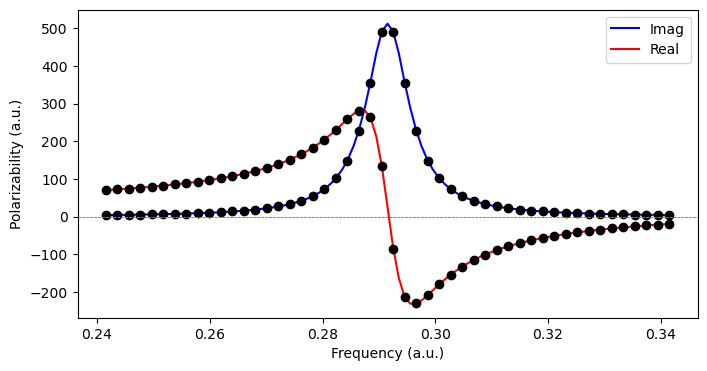

In [37]:
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

fig = plt.figure(1,figsize=(8,4))

x = np.arange(exc - 0.05, exc + 0.05, 0.001)
yR = interp1d(freqs, alpha_xx.real, kind = 'cubic')
yI = interp1d(freqs, alpha_xx.imag, kind = 'cubic')

plt.plot(x, yI(x), 'b-', x, yR(x), 'r-')
plt.plot(freqs, alpha_xx.real, 'ko', freqs, alpha_xx.imag, 'ko')

plt.legend(['Imag', 'Real'])

plt.axhline(y = 0, color = '0.5', linewidth = 0.7, dashes = [3,1,3,1])

plt.ylabel('Polarizability (a.u.)')
plt.xlabel('Frequency (a.u.)')

plt.show()